In [1]:
# This code evolves the Einstein-Klein Gordon system of equations in the 3+1 decomposition 
# using the reference metric approach in arXiv:1211.6632
# to avoid coordinate singularities in the right hand side evolution
# Spherical symmetry is assumed and the outer boundary condition is 
# extrapolation at zeroth order

# load the required python modules
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import time
import random
import matplotlib.pyplot as plt
%matplotlib inline

# homemade code
from myparams import *                         # go here to change the grid and other params
from source.rhsevolution import *              # go here to look at how the evolution works
from myinitialconditions import *       # go here to change the initial conditions
from source.diagnostics import *               # go here to change the initial conditions

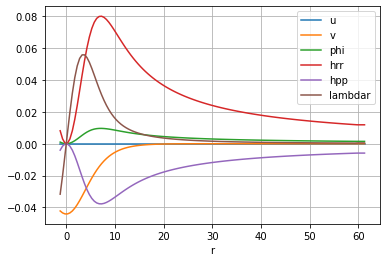

In [2]:
initial_vars_values = get_initial_vars_values()

#unpackage the vector for readability
initial_u   = initial_vars_values[idx_u * N : (idx_u + 1) * N]
initial_v   = initial_vars_values[idx_v * N : (idx_v + 1) * N]
initial_phi = initial_vars_values[idx_phi * N : (idx_phi + 1) * N]
#initial_chi = np.exp(-4.0*initial_phi)
initial_hrr = initial_vars_values[idx_hrr * N : (idx_hrr + 1) * N]
initial_hpp = initial_vars_values[idx_hpp * N : (idx_hpp + 1) * N]
initial_lambdar = initial_vars_values[idx_lambdar * N : (idx_lambdar + 1) * N]

#plot initial conditions
plt.xlabel('r')
plt.plot(r, initial_u, label='u')
plt.plot(r, initial_v, label='v')
plt.plot(r, initial_phi, label='phi')
plt.plot(r, initial_hrr, label='hrr')
plt.plot(r, initial_hpp, label='hpp')
plt.plot(r, initial_lambdar, label='lambdar')
plt.legend(loc='best')
plt.grid()

In [3]:
#solve for the solution

if (USE_ODEINT):
    solution = odeint(get_rhs, initial_vars_values, t, args=(0, 0), 
                      atol=1e-5, rtol=1e-5, hmin=min_dt, mxstep=max_steps)

else:
    # The solve_ivp routine allows one to choose the ODE solver
    # To use it we need to change the syntax of the rhs function
    # because solve_ivp assumes the rhs to be the form get_rhs(t_i, vars_vec)
    # Rather than get_rhs(vars_vec, t_i) as in odeint
    # So I use a lambda function to swap the first two arguments:
    get_rhs_solve_ivp = lambda t_i, vars_vec, p, q: get_rhs(vars_vec, t_i, p, q)

    # Call solve_ivp to use the RK45 solver 
    dense_solution = solve_ivp(get_rhs_solve_ivp, [0,T], initial_vars_values, args=(0, 0),
                         atol=1e-5, rtol=1e-5,
                         method='RK45', dense_output=True)

    # Interpolate the solution at the time points defined in myparams.py
    solution = dense_solution.sol(t).T
    #print(solution.shape)

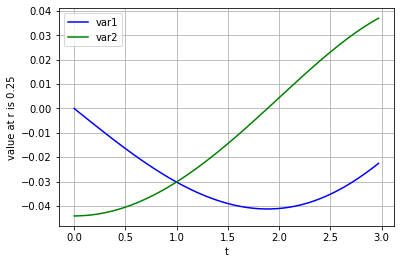

In [4]:
# Plot a single point versus time

var1 = idx_u
var2 = idx_v

idx = num_ghosts
r_i = np.round(r[idx],2)
u_of_t = solution[0:N_t, var1 * N + idx]
plt.plot(t, u_of_t, 'b-', label='var1')
v_of_t = solution[0:N_t, var2 * N + idx]
plt.plot(t, v_of_t, 'g-', label='var2')
plt.legend(loc='best')
plt.xlabel('t')
plt.ylabel('value at r is '+str(r_i))
plt.legend(loc='best')
plt.grid()

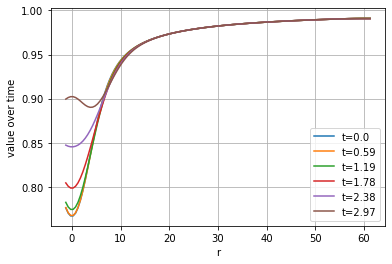

In [15]:
# plot the profile for some variable at a selection of times
var = idx_lapse

for i, t_i in enumerate(t) :
    if (i < N_t) and (i % 20 == 0) :
        labelt = "t="+str(round(t_i,2))
        f_t = solution[i, var * N: (var + 1) * N]
        plt.plot(r, f_t, label=labelt)

plt.legend(loc=4)
plt.xlabel('r')
plt.ylabel('value over time')
plt.grid()

In [16]:
# calculate the diagnostics, just the Hamiltonian constraint for now
Ham = get_diagnostics(solution)

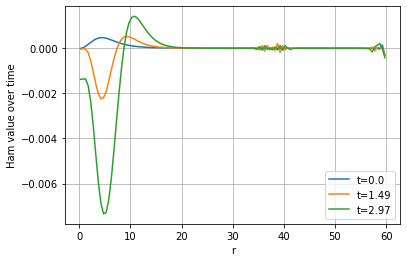

In [17]:
# plot the profile for Ham at a selection of times

for i, t_i in enumerate(t) :
    if (i < N_t) and (i % 50 == 0) :
        labelt = "t="+str(round(t_i,2))
        Ham_t = Ham[i]
        Ham_t = Ham_t[num_ghosts:(N-num_ghosts)]
        r_diagnostics = r[num_ghosts:(N-num_ghosts)]
        plt.plot(r_diagnostics, Ham_t, label=labelt)

plt.legend(loc=4)
plt.xlabel('r')
plt.ylabel('Ham value over time')
plt.grid()